In [105]:
import yfinance as yf
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [116]:
# Create a dictionary to store data from each worksheet
data_dict = {}

# Read each worksheet and store the data in the dictionary
with pd.ExcelFile('Financial_Dataset.xlsx') as xls:
    for sheet_name in xls.sheet_names:
        data_dict[sheet_name] = pd.read_excel(xls, sheet_name)

# Print the data from each worksheet
# for sheet_name, data in data_dict.items():
#     print(f"Data from sheet '{sheet_name}':")
#     print(type(data))

In [117]:
# Another dictionary to organize the Quarterly reports by year
ppDataDict = {}

for sheet_name, data in data_dict.items():
    for i in range(1, len(data_dict[sheet_name].index)):
        row_values = data_dict[sheet_name].iloc[i].tolist()
        rowDate = processDataInfo(row_values[0], False)
        
        try:
            ppDataDict[sheet_name][rowDate[0]].append(row_values)
        except KeyError:
            try:
                ppDataDict[sheet_name][rowDate[0]] = [row_values]
            except KeyError:
                ppDataDict[sheet_name] = {}
       
print(ppDataDict["AAPL"][2014])

[['2014-01', 225184, 80347, 95500, 53769, '13072 | 22670', '22670 | 23426', '-15103 | -13521', '-7749 | -4497', '14077 | 16154', 3], ['2014-04', 205989, 70541, 85810, 43208, '23295 | 22625', '36208 | 35930', '-3362 | -27878', '-28156 | -6745', '18949 | 12053', 6], ['2014-07', 222520, 67949, 101580, 46205, '31043 | 29525', '46463 | 43758', '-25576 | -34385', '-22169 | -8871', '12977 | 11248', 9], ['2014-10', 231839, 68531, 120292, 63448, '39510 | 37037', '59713 | 53666', '-22579 | -33774', '-37549 | -16379', '13844 | 14259', 12]]


In [98]:
def processDataInfo(s, isTicker):
    res = 0
    orderYM = (0, 0)
    if isTicker:
        parts = s.split()
        orderT = parts[0]
        orderYM = (int(parts[1][:4]), int(parts[1][-2:]), orderT)
    else:
        orderYM = (int(s[:4]), int(s[-2:]))
    res = orderYM
    return res

def getLastTwoQuartData(ticker, year, quart):
    y = year
    return ppDataDict[ticker][y-1 if quart-1 <= -1 else y][quart-1], ppDataDict[ticker][y-1 if quart-2 <= -1 else y][quart-2]
    
testRes = []
    
# What inside of loop will look like
validMonth = 'AAPL 2011-11'

# validMonth = ticker+ " " + monthlyDf.index[i].strftime('%Y-%m')
            
ymt = processDataInfo(validMonth, True)

quartArr = ppDataDict[ymt[2]][ymt[0]][-1]
prevQuartArr = ppDataDict[ymt[2]][ymt[0]][-2]
# ymt[0] = Year,   ymt[1] = Month,   ymt[2] = Ticker
for j in range (len(ppDataDict[ymt[2]][ymt[0]])):
    checkMonth = processDataInfo(ppDataDict[ymt[2]][ymt[0]][j][0], False)[1]
    print(str(checkMonth) + "  " + str(ymt[1]) + "   " + str(checkMonth > ymt[1]))
    if checkMonth > ymt[1]:
        quartArr, prevQuartArr = getLastTwoQuartData(ymt[2], ymt[0], j)
        break

print(quartArr)
print(prevQuartArr)



1  11   False
4  11   False
7  11   False
10  11   False
['2011-10', '116371', 44988, '39756', 27970, '25922 | 14013', '37529 | 18595', '-40419 | -13854', '1444 | 1257', '9815 | 11261', 12]
['2011-07', '106758', 46898, '37415', 26859, '19299 | 9705', '27100 | 12912', '-27283 | -9471', '1013 | 1001', '12091 | 9705', 9]


In [185]:
def processDataInfo(s, isTicker):
    res = 0
    orderYM = (0, 0)
    if isTicker:
        parts = s.split()
        orderT = parts[0]
        orderYM = (int(parts[1][:4]), int(parts[1][-2:]), orderT)
    else:
        orderYM = (int(s[:4]), int(s[-2:]))
    res = orderYM
    return res

def getLastTwoQuartData(ticker, year, quart):
    y = year
    return ppDataDict[ticker][y-1 if quart-1 <= -1 else y][quart-1], ppDataDict[ticker][y-1 if quart-2 <= -1 else y][quart-2]

def gatherDataset(ticker, currData):
    dataset = currData
    
    tickerData = yf.Ticker(ticker)
    # Get all data from last decade
    tickerDf = tickerData.history(start="2010-06-01", end="2022-12-25")
    # Resample average monthly price data
    monthlyDf = tickerDf.resample('M').mean()
    
    for i in range(7, len(monthlyDf)):
        monthData = []
        validMonth = ticker+ " " + monthlyDf.index[i].strftime('%Y-%m')

        # ymt[0] = Year,   ymt[1] = Month,   ymt[2] = Ticker
        ymt = processDataInfo(validMonth, True)

        # Default 'quartArr' and 'prevQuartArr' to last two quarter of year, in case following loop finishes without the checked Month being lower.
        quartArr = ppDataDict[ymt[2]][ymt[0]][-1]
        prevQuartArr = ppDataDict[ymt[2]][ymt[0]][-2]
        for j in range (len(ppDataDict[ymt[2]][ymt[0]])):
            checkMonth = processDataInfo(ppDataDict[ymt[2]][ymt[0]][j][0], False)[1]
            if checkMonth > ymt[1]:
                quartArr, prevQuartArr = getLastTwoQuartData(ymt[2], ymt[0], j)
                break

        #print(quartArr)

        # ------------- STOCK STATISTIC DATA -------------------------------

        # Month
        monthData.append(validMonth)

        # 1 Month Close Diff%
        monthData.append(1 - (monthlyDf["Close"][i-2] / monthlyDf["Close"][i-1]))

        # 3 Month Close Diff%
        monthData.append(1 - (monthlyDf["Close"][i-4] / monthlyDf["Close"][i-1]))

        # 6 Month Close Diff%
        monthData.append(1 - (monthlyDf["Close"][i-7] / monthlyDf["Close"][i-1]))

        # 1 Month High Diff%
        monthData.append(1 - (monthlyDf["High"][i-2] / monthlyDf["High"][i-1]))

        # 3 Month High Diff%
        monthData.append(1 - (monthlyDf["High"][i-4] / monthlyDf["High"][i-1]))

        # 6 Month High Diff%
        monthData.append(1 - (monthlyDf["High"][i-7] / monthlyDf["High"][i-1]))

        # 1 Month Low Diff%
        monthData.append(1 - (monthlyDf["Low"][i-2] / monthlyDf["Low"][i-1]))

        # 3 Month Low Diff%
        monthData.append(1 - (monthlyDf["Low"][i-4] / monthlyDf["Low"][i-1]))

        # 6 Month Low Diff%
        monthData.append(1 - (monthlyDf["Low"][i-7] / monthlyDf["Low"][i-1]))

        # Volume Diff% (Compared against prev 6 month average)
        sum = 0
        for j in range(2,8):
            sum += monthlyDf["Volume"][i-j]
        sum /= 6
        vol = 1 - (sum / monthlyDf["Volume"][i-1])
        monthData.append(vol)

        # -------------- Quarterly Report Data ----------------------

        # 1Q Total Asset Comparision
        monthData.append(1 - int(quartArr[1]) / int(prevQuartArr[1]))

        # 1Q Current Asset Comparision
        monthData.append(1 - int(quartArr[2]) / int(prevQuartArr[2]))

        # 1Q Total Liabilities Comparision
        monthData.append(1 - int(quartArr[3]) / int(prevQuartArr[3]))

        # 1Q Current Liabilities Comparision
        monthData.append(1 - int(quartArr[4]) / int(prevQuartArr[4]))

        # 1Q Net Income (Comparing previous month)
        a, b = map(int, quartArr[5].split('|')) # Net income data for the current quarter
        c, d = map(int, prevQuartArr[5].split('|')) # Net income data for the previous quarter
        try:
            monthData.append(1 - a / c)
        except ZeroDivisionError:
            # If c is 0, then rturn the sign of a
            monthData.append(-1 if a < 0 else 1)

        # SUB Net Income (Comparing data used in report)
        a, b = map(int, quartArr[5].split('|')) # Net income data for the current quarter
        try:
            monthData.append(1 - a / b)
        except ZeroDivisionError:
            monthData.append(-1 if a < 0 else 1)

        # 1Q Operating Budget (Comparing previous month)
        a, b = map(int, quartArr[6].split('|')) # Operating Budget data for the current quarter
        c, d = map(int, prevQuartArr[6].split('|')) # Operating Budget data for the previous quarter
        try:
            monthData.append(1 - a / c)
        except ZeroDivisionError:
            # If c is 0, then rturn the sign of a
            monthData.append(-1 if a < 0 else 1)

        # SUB Operating Budget (Comparing data used in report)
        a, b = map(int, quartArr[6].split('|')) # Operating Budget data for the current quarter
        try:
            monthData.append(1 - a / b)
        except ZeroDivisionError:
            monthData.append(-1 if a < 0 else 1)

        # 1Q Investing Budget (Comparing previous month)
        a, b = map(int, quartArr[7].split('|')) # Investing Budget data for the current quarter
        c, d = map(int, prevQuartArr[7].split('|')) # Investing Budget data for the previous quarter
        try:
            monthData.append(1 - a / c)
        except ZeroDivisionError:
            # If c is 0, then rturn the sign of a
            monthData.append(-1 if a < 0 else 1)

        # SUB Investing Budget (Comparing data used in report)
        a, b = map(int, quartArr[7].split('|')) # Investing Budget data for the current quarter
        try:
            monthData.append(1 - a / b)
        except ZeroDivisionError:
            monthData.append(-1 if a < 0 else 1)

        # 1Q Finance Budget (Comparing previous month)
        a, b = map(int, quartArr[8].split('|')) # Investing Budget data for the current quarter
        c, d = map(int, prevQuartArr[8].split('|')) # Investing Budget data for the previous quarter
        try:
            monthData.append(1 - a / c)
        except ZeroDivisionError:
            # If c is 0, then rturn the sign of a
            monthData.append(-1 if a < 0 else 1)

        # SUB Finance Budget (Comparing data used in report)
        a, b = map(int, quartArr[8].split('|')) # Investing Budget data for the current quarter
        try:
            monthData.append(1 - a / b)
        except ZeroDivisionError:
            monthData.append(-1 if a < 0 else 1)

        # 1Q Ending Cash for Quarter (Comparing previous month)
        a, b = map(int, quartArr[9].split('|')) # Ending Cash data for the current quarter
        c, d = map(int, prevQuartArr[9].split('|')) # Ending Cash data for the previous quarter
        try:
            monthData.append(1 - a / c)
        except ZeroDivisionError:
            # If c is 0, then rturn the sign of a
            monthData.append(-1 if a < 0 else 1)

        # SUB Ending Cash for Quarter (Comparing data used in report)
        a, b = map(int, quartArr[9].split('|')) # Ending Cash data for the current quarter
        try:
            monthData.append(1 - a / b)
        except ZeroDivisionError:
            monthData.append(-1 if a < 0 else 1)

        # Miscellaneous quarterly data for graph plotting
        # (x, y, z) = (Total Cash, Total Assets, Net Income)
        monthData.append((quartArr[9], quartArr[1], quartArr[5]))

        # Next Month Close
        monthData.append(monthlyDf["Close"][i])

        # Label
        if monthlyDf["Close"][i] > monthlyDf["Close"][i-1]:
            monthData.append(1)
        else:
            monthData.append(0)

        dataset.append(monthData)
        
    
    return dataset

In [186]:
data = [["Month", "1M Close", "3M Close", "6M Close", "1M High", "3M High", "6M High", "1M Low", "3M Low", "6M Low", "Volume", "1Q Total Asset", "1Q Current Asset",
         "1Q Total Liabilities", "1Q Current Liabilities", "1Q Net Income", "SUB Net Income", "1Q Operating Budget", "SUB Operating Budget", "1Q Investing Budget", "SUB Investing Budget", 
         "1Q Finance Budget", "SUB Finance Budget", "1Q Total Cash", "SUB Total Cash", "MISC Data", "NextM Close", "Label"]]
feature_cols = data[0][1:-2]

# trainingTickers = ["GOOG", "AAPL", "MSFT", "AMZN", "NVDA", "PYPL", "NFLX", "AMD", "CSCO", "DVN"]
trainingTickers = ["AAPL", "AMD", "AMZN", "CSCO", "DVN"]

for tick in trainingTickers:
    data = gatherDataset(tick, data)

print(len(data))
print(data[1:3])

721
[['AAPL 2011-01', 0.03078775941121248, 0.1481712377127934, 0.18769235721762856, 0.02813406993981593, 0.14633231599902952, 0.18003779724813684, 0.035000823638377976, 0.15444472103526508, 0.19254664494782192, -0.8606497135781705, -0.15374486253541364, -0.05396132252027441, -0.17099883177570097, -0.14829649647717402, 0.5715407121958181, -0.7773830669034931, 0.47442860984135515, -0.6905379692094793, 0.22556662335787503, -1.710712481051036, 0.6587112171837709, 0.17973231357552577, 0.04679868572950896, -0.4106978577999738, ('10734 | 7609', 86742, '6004 | 3378'), 10.285765838623046, 1], ['AAPL 2011-02', 0.049926421962917744, 0.11066179176937196, 0.24655723045592826, 0.052134806603821526, 0.11015695231206879, 0.2416776361155928, 0.04295393219682986, 0.10974828102178769, 0.24906140506209695, 0.047288237945878775, -0.15374486253541364, -0.05396132252027441, -0.17099883177570097, -0.14829649647717402, 0.5715407121958181, -0.7773830669034931, 0.47442860984135515, -0.6905379692094793, 0.2255666

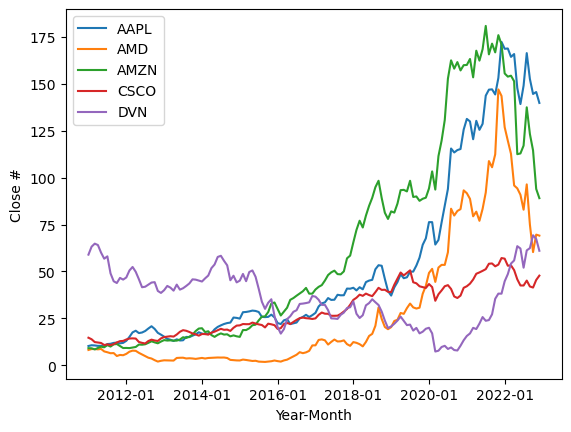

In [187]:
# Raw stock market data chart
graphData = {
    'AAPL': [],
    'AMD': [],
    'AMZN': [],
    'CSCO': [],
    'DVN': []
}

for arr in data[1:]:
    # Combine the year and month for organization purposes
    parts = arr[0].split()
    yearMonth = parts[1]
    graphData[parts[0]].append((yearMonth, arr[-2]))
    
# Iterate over graphData and plot each list as a separate line
for line_label, line_data in graphData.items():
    x_values = [t[0] for t in line_data]
    y_values = [t[1] for t in line_data]
    plt.plot(x_values, y_values, label=line_label)
    
# Set x-axis tick marks and corresponding labels
x_ticks =  ['2012-01', '2014-01', '2016-01', '2018-01', '2020-01', '2022-01']  # Values to be displayed
x_tick_labels = ['2012-01', '2014-01', '2016-01', '2018-01', '2020-01', '2022-01'] # Labels for each tick mark
plt.xticks(x_ticks, x_tick_labels)


# Add legend and axis labels
plt.legend()
plt.xlabel('Year-Month')
plt.ylabel('Close #')

# Show the plot
plt.show()

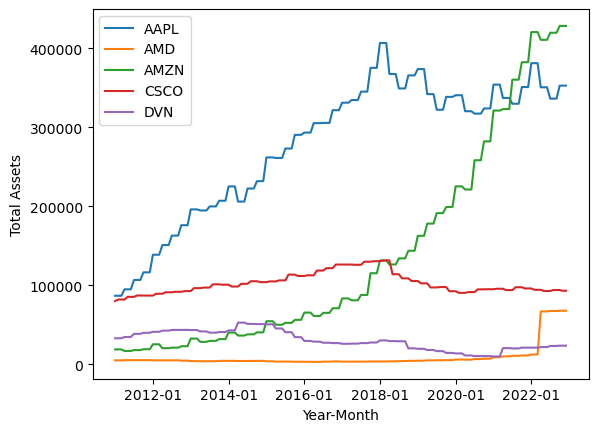

In [188]:
# Quarterly Report data chart (Total assets)
graphData = {
    'AAPL': [],
    'AMD': [],
    'AMZN': [],
    'CSCO': [],
    'DVN': []
}

for arr in data[1:]:
    # Combine the year and month for organization purposes
    parts = arr[0].split()
    yearMonth = parts[1]
    graphData[parts[0]].append((yearMonth, arr[-3][1]))
    
# Iterate over graphData and plot each list as a separate line
for line_label, line_data in graphData.items():
    x_values = [t[0] for t in line_data]
    y_values = [t[1] for t in line_data]
    plt.plot(x_values, y_values, label=line_label)
    
# Set x-axis tick marks and corresponding labels
x_ticks =  ['2012-01', '2014-01', '2016-01', '2018-01', '2020-01', '2022-01']  # Values to be displayed
x_tick_labels = ['2012-01', '2014-01', '2016-01', '2018-01', '2020-01', '2022-01'] # Labels for each tick mark
plt.xticks(x_ticks, x_tick_labels)


# Add legend and axis labels
plt.legend()
plt.xlabel('Year-Month')
plt.ylabel('Total Assets')

# Show the plot
plt.show()

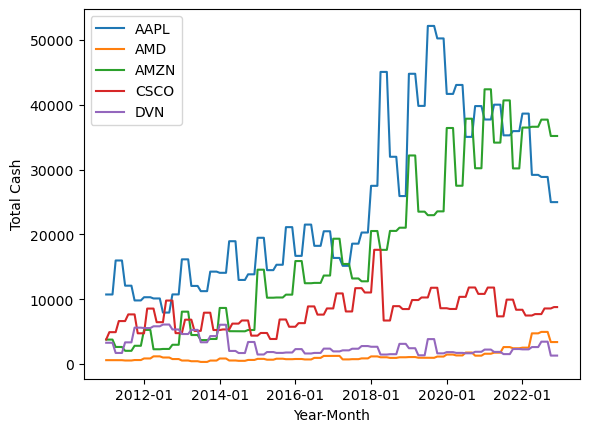

In [189]:
# Quarterly Report data chart (Total Cash)
graphData = {
    'AAPL': [],
    'AMD': [],
    'AMZN': [],
    'CSCO': [],
    'DVN': []
}

for arr in data[1:]:
    # Combine the year and month for organization purposes
    parts = arr[0].split()
    yearMonth = parts[1]
    totalCash = arr[-3][0].split('|')
    graphData[parts[0]].append((yearMonth, int(totalCash[0])))
    
# Iterate over graphData and plot each list as a separate line
for line_label, line_data in graphData.items():
    x_values = [t[0] for t in line_data]
    y_values = [t[1] for t in line_data]
    plt.plot(x_values, y_values, label=line_label)
    
# Set x-axis tick marks and corresponding labels
x_ticks =  ['2012-01', '2014-01', '2016-01', '2018-01', '2020-01', '2022-01']  # Values to be displayed
x_tick_labels = ['2012-01', '2014-01', '2016-01', '2018-01', '2020-01', '2022-01'] # Labels for each tick mark
plt.xticks(x_ticks, x_tick_labels)


# Add legend and axis labels
plt.legend()
plt.xlabel('Year-Month')
plt.ylabel('Total Cash')

# Show the plot
plt.show()

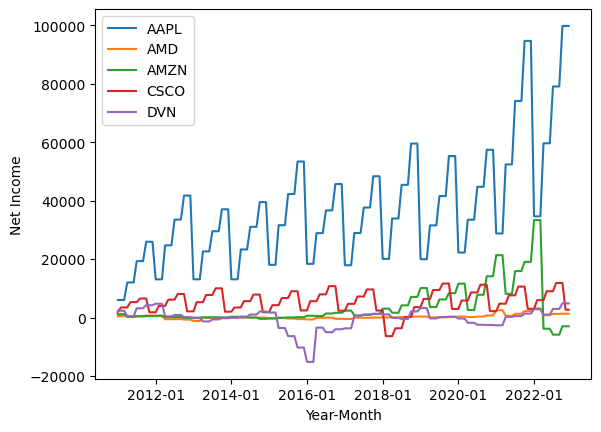

In [184]:
# Quarterly Report data chart (Total Cash)
graphData = {
    'AAPL': [],
    'AMD': [],
    'AMZN': [],
    'CSCO': [],
    'DVN': []
}

for arr in data[1:]:
    # Combine the year and month for organization purposes
    parts = arr[0].split()
    yearMonth = parts[1]
    totalCash = arr[-3][2].split('|')
    graphData[parts[0]].append((yearMonth, int(totalCash[0])))
    
# Iterate over graphData and plot each list as a separate line
for line_label, line_data in graphData.items():
    x_values = [t[0] for t in line_data]
    y_values = [t[1] for t in line_data]
    plt.plot(x_values, y_values, label=line_label)
    
# Set x-axis tick marks and corresponding labels
x_ticks =  ['2012-01', '2014-01', '2016-01', '2018-01', '2020-01', '2022-01']  # Values to be displayed
x_tick_labels = ['2012-01', '2014-01', '2016-01', '2018-01', '2020-01', '2022-01'] # Labels for each tick mark
plt.xticks(x_ticks, x_tick_labels)


# Add legend and axis labels
plt.legend()
plt.xlabel('Year-Month')
plt.ylabel('Net Income')

# Show the plot
plt.show()

In [126]:
# Create a DataFrame from the list of lists
df = pd.DataFrame(data[1:], columns=data[0]).set_index('Month')

X = df[feature_cols]
y = df["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=2)

In [127]:
print(X)

              1M Close  3M Close  6M Close   1M High   3M High   6M High  \
Month                                                                      
AAPL 2011-01  0.030788  0.148171  0.187692  0.028134  0.146332  0.180038   
AAPL 2011-02  0.049926  0.110662  0.246557  0.052135  0.110157  0.241678   
AAPL 2011-03  0.036456  0.112746  0.284352  0.034936  0.110985  0.281512   
AAPL 2011-04 -0.010624  0.074836  0.211919 -0.008076  0.077862  0.212801   
AAPL 2011-05 -0.020784  0.005979  0.115979 -0.019320  0.008347  0.117585   
...                ...       ...       ...       ...       ...       ...   
DVN 2022-08  -0.196597 -0.074130  0.139165 -0.212217 -0.082272  0.133171   
DVN 2022-09   0.150773 -0.036633  0.206580  0.152993 -0.039903  0.203444   
DVN 2022-10   0.019220  0.003348  0.131852  0.021878 -0.004292  0.131414   
DVN 2022-11   0.098880  0.249453  0.193815  0.095627  0.250750  0.189107   
DVN 2022-12  -0.029366  0.090245  0.056918 -0.026090  0.092335  0.056117   

           

In [144]:
# Initalize model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(len(feature_cols), activation='relu'),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)


Epoch 1/50
468/468 - 1s - loss: 1.0385 - accuracy: 0.5150 - 1s/epoch - 3ms/step
Epoch 2/50
468/468 - 0s - loss: 0.8368 - accuracy: 0.5620 - 418ms/epoch - 893us/step
Epoch 3/50
468/468 - 0s - loss: 0.7187 - accuracy: 0.5897 - 417ms/epoch - 892us/step
Epoch 4/50
468/468 - 0s - loss: 0.7274 - accuracy: 0.6154 - 425ms/epoch - 908us/step
Epoch 5/50
468/468 - 0s - loss: 0.7189 - accuracy: 0.6175 - 417ms/epoch - 892us/step
Epoch 6/50
468/468 - 0s - loss: 0.6825 - accuracy: 0.6389 - 429ms/epoch - 916us/step
Epoch 7/50
468/468 - 0s - loss: 0.6501 - accuracy: 0.6282 - 421ms/epoch - 899us/step
Epoch 8/50
468/468 - 0s - loss: 0.6552 - accuracy: 0.6282 - 417ms/epoch - 891us/step
Epoch 9/50
468/468 - 0s - loss: 0.6386 - accuracy: 0.6709 - 414ms/epoch - 884us/step
Epoch 10/50
468/468 - 0s - loss: 0.6380 - accuracy: 0.6453 - 416ms/epoch - 888us/step
Epoch 11/50
468/468 - 0s - loss: 0.6424 - accuracy: 0.6453 - 421ms/epoch - 899us/step
Epoch 12/50
468/468 - 0s - loss: 0.6249 - accuracy: 0.6709 - 413ms/e

In [145]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

8/8 - 0s - loss: 1.3334 - accuracy: 0.5794 - 181ms/epoch - 23ms/step
Test Loss: 1.3333555459976196, Test Accuracy: 0.579365074634552


In [190]:
# def changeDate(baseYear, baseMonth, amount):
#     resMonth = baseMonth + amount
#     resYear = baseYear
    
#     if resMonth <= 0:
#         resMonth = 12 + resMonth
#         resYear -= 1    
#     if resMonth > 12:
#         resYear += 1
#     resMonth = resMonth % 12
#     if resMonth == 0:
#         resMonth = 12
    
#     resMonth = str(resMonth)
#     resYear = str(resYear)
    
#     if len(resMonth) == 1:
#         resMonth = "0" + resMonth
#     return resYear + "-" + resMonth + "-1"


# def getPrediction(predictionModel, ticker, year, month, confThreshold):
#     data = [["Month", "1M Close", "3M Close", "6M Close", "1M High", "3M High", "6M High", "1M Low", "3M Low", "6M Low", "Volume"]]
    
    
#     tickerData = yf.Ticker(ticker)
    
#     # Resample average monthly price data
#     nextMonthData = tickerData.history(start=changeDate(year, month, 1), end=changeDate(year, month, 2)).resample('M').mean()
#     predMonthData = tickerData.history(start=changeDate(year, month, 0), end=changeDate(year, month, 1)).resample('M').mean()
#     lastMonthData = tickerData.history(start=changeDate(year, month, -1), end=changeDate(year, month, 0)).resample('M').mean()
#     threeMonthData = tickerData.history(start=changeDate(year, month, -3), end=changeDate(year, month, -2)).resample('M').mean()
#     sixMonthData = tickerData.history(start=changeDate(year, month, -6), end=changeDate(year, month, -5)).resample('M').mean()
    
#     # return predMonthData["Open"].iloc[0]
    
#     monthData = []
    
#     # Month
#     monthData.append(ticker+ " " + predMonthData.index[0].strftime('%Y-%m'))

#     # 1 Month Close Diff%
#     monthData.append(1 - (lastMonthData["Close"].iloc[0] / predMonthData["Close"].iloc[0]))

#     # 3 Month Close Diff%
#     monthData.append(1 - (threeMonthData["Close"].iloc[0] / predMonthData["Close"].iloc[0]))

#     # 6 Month Close Diff%
#     monthData.append(1 - (sixMonthData["Close"].iloc[0] / predMonthData["Close"].iloc[0]))

#     # 1 Month High Diff%
#     monthData.append(1 - (lastMonthData["High"].iloc[0] / predMonthData["High"].iloc[0]))

#     # 3 Month High Diff%
#     monthData.append(1 - (threeMonthData["High"].iloc[0] / predMonthData["High"].iloc[0]))

#     # 6 Month High Diff%
#     monthData.append(1 - (sixMonthData["High"].iloc[0] / predMonthData["High"].iloc[0]))

#     # 1 Month Low Diff%
#     monthData.append(1 - (lastMonthData["Low"].iloc[0] / predMonthData["Low"].iloc[0]))

#     # 3 Month Low Diff%
#     monthData.append(1 - (threeMonthData["Low"].iloc[0] / predMonthData["Low"].iloc[0]))

#     # 6 Month Low Diff%
#     monthData.append(1 - (sixMonthData["Low"].iloc[0] / predMonthData["Low"].iloc[0]))

#     # Volume Diff% (Compared against prev 6 month average)
#     sum = lastMonthData["Volume"].iloc[0] + threeMonthData["Volume"].iloc[0] + sixMonthData["Volume"].iloc[0]
#     sum /= 3
    
#     vol = 1 - (sum / predMonthData["Volume"].iloc[0])
#     monthData.append(vol)
    
#     data.append(monthData)

#     dataset = pd.DataFrame(data[1:], columns=data[0]).set_index('Month')    
    
#     # Use the predict method to get the output from the model
#     output = model.predict(dataset)
    
#     print(output[0][0])

#     prediction = 0
#     if output[0][0] >= confThreshold:
#         prediction = 1

#     # print(prediction)
    
#     correct_prediction = 0
#     if predMonthData["Close"].iloc[0] < nextMonthData["Close"].iloc[0]:
#         correct_prediction = 1
    
#     return prediction, correct_prediction, predMonthData["Close"].iloc[0], nextMonthData["Close"].iloc[0]




In [191]:
# halfPredTickers = ["AAPL", "GOOG", "MSFT", "NVDA", "AMZN", "SONY", "INTC", "NTDOY", "TSLA", "BA"]

# predBuys = 0
# actualBuys = 0
# buyerAcc = 0


# for tick in halfPredTickers:
#     pred, corrPred, thisClose, nextClose = getPrediction(model, tick, 2020, 7, 0.6)
#     predBuys += pred
#     actualBuys += corrPred
    
#     if pred and corrPred:
#         buyerAcc += 1
    
#     print(tick + "  Predicted Label:" + str(pred) + "  Actual Label:" + str(corrPred) + "  This Close:" + str(thisClose) + "  Next Close:" + str(nextClose))

# print("Predicted: "+str(predBuys)+"   Actual: "+str(actualBuys)+"   Correct Buys: "+str(buyerAcc))


In [192]:
# fullPredTickers = ["ADBE", "IBM", "ORCL", "EA", "PARA", "DIS", "KDP", "KO", "T", "WFC"]

# predBuys = 0
# actualBuys = 0
# buyerAcc = 0


# for tick in fullPredTickers:
#     pred, corrPred, thisClose, nextClose = getPrediction(model, tick, 2020, 7, 0.6)
#     predBuys += pred
#     actualBuys += corrPred
    
#     if pred and corrPred:
#         buyerAcc += 1
    
#     print(tick + "  Predicted Label:" + str(pred) + "  Actual Label:" + str(corrPred) + "  This Close:" + str(thisClose) + "  Next Close:" + str(nextClose))

# print("Predicted: "+str(predBuys)+"   Actual: "+str(actualBuys)+"   Correct Buys: "+str(buyerAcc))

In [193]:
# def changeDate(baseYear, baseMonth, amount):
#     resMonth = baseMonth + amount
#     resYear = baseYear
    
#     if resMonth <= 0:
#         resMonth = 12 + resMonth
#         resYear -= 1    
#     if resMonth > 12:
#         resYear += 1
#     resMonth = resMonth % 12
#     if resMonth == 0:
#         resMonth = 12
    
#     resMonth = str(resMonth)
#     resYear = str(resYear)
    
#     if len(resMonth) == 1:
#         resMonth = "0" + resMonth
#     return resYear + "-" + resMonth + "-1"


# print(changeDate(2010, 11, 2))
# print(changeDate(2010, 10, -3))
# print(changeDate(2010, 4, -6))
# print(changeDate(2022, 1, -1))